<a href="https://colab.research.google.com/github/joeDastan/TextClassification/blob/main/TextClassification_AddingAttentionLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text Classification**


---


In This Code We Try To Modify And Enchance Tensorflow's Website Tutorial The https://www.tensorflow.org/tutorials/keras/text_classification In Order To Get Better Result

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

Importing dataset

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1/aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
os.listdir(dataset_dir)

['train', 'imdbEr.txt', 'README', 'imdb.vocab', 'test']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'unsup',
 'urls_neg.txt',
 'urls_pos.txt',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_unsup.txt']

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Prepare Dataset

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [17]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating Model

In [20]:
embedding_dim = 16

In [21]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:

# --- Configuration (using your existing variables) ---

num_heads = 2         # Number of attention heads for MultiHeadAttention
key_dim = 256         # Dimension of the key/value/query

def build_attention_model(max_features, embedding_dim, num_heads, key_dim):

    # 1. Input Layer
    inputs = layers.Input(shape=(None,), dtype='float32', name='input_sequence')

    # 2. Embedding Layer
    # Output shape: (batch_size, sequence_length, embedding_dim)
    x = layers.Embedding(max_features, embedding_dim)(inputs)

    # 3.ADDING THE ATTENTION LAYER (Self-Attention)
    # MultiHeadAttention works great for self-attention:
    # The Query, Key, and Value all come from the same input (x).

    # The attention layer processes the entire sequence, determining the
    # importance of each word's embedding relative to every other word.

    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        name="self_attention"
    )(query=x, key=x, value=x)

    # 4. Add & Normalize (often used after Attention)
    # This maintains the skip connection pattern used in Transformers.
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    x = layers.Dropout(0.2)(x)

    # 5. Global Pooling
    # Now that the attention layer has re-weighted and re-combined the
    # sequence features, we can collapse the sequence dimension.
    # Output shape: (batch_size, embedding_dim)
    x = layers.GlobalAveragePooling1D()(x)

    # 6. Dropout and Dense for Classification
    x = layers.Dropout(0.2)(x)


    # Output layer for binary classification (sentiment, spam, etc.)
    outputs = layers.Dense(1, activation='sigmoid', name='output_prediction')(x)

    # Final Model Definition
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Attention_Classifier')

    return model

# --- Instantiate and Summarize the Model ---

attention_model = build_attention_model(max_features, embedding_dim, num_heads, key_dim)

print(attention_model.summary())


Model: "Attention_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 16)  │    160,000 │ input_sequence[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, None, 16)  │     34,320 │ embedding_3[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_3[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 16)  │          0 │ embedding_3[0][0… │
│                     │                   │            │ self_attention[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 16)  │         32 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, None, 16)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_9[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_prediction   │ (None, 1)         │         17 │ dropout_10[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 194,369 (759.25 KB)

 Trainable params: 194,369 (759.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
attention_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [48]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [49]:
epochs = 4
history = attention_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - binary_accuracy: 0.6913 - loss: 0.5543 - val_binary_accuracy: 0.8816 - val_loss: 0.2932
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - binary_accuracy: 0.9048 - loss: 0.2429 - val_binary_accuracy: 0.8772 - val_loss: 0.2948
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - binary_accuracy: 0.9389 - loss: 0.1733 - val_binary_accuracy: 0.8732 - val_loss: 0.3348
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - binary_accuracy: 0.9524 - loss: 0.1440 - val_binary_accuracy: 0.8628 - val_loss: 0.3917


In [50]:
epochs = 6
historyOld = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.9230 - loss: 0.2049 - val_binary_accuracy: 0.8636 - val_loss: 0.3111
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9294 - loss: 0.1966 - val_binary_accuracy: 0.8688 - val_loss: 0.3075
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9341 - loss: 0.1877 - val_binary_accuracy: 0.8678 - val_loss: 0.3086
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.9346 - loss: 0.1797 - val_binary_accuracy: 0.8674 - val_loss: 0.3111
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9409 - loss: 0.1710 - val_binary_accuracy: 0.8694 - val_loss: 0.3104
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9426 - loss: 0.1652 - val_binary_accuracy: 0.8696 - val_loss: 0.3131


In [51]:
loss, accuracy = attention_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8408 - loss: 0.4586
Loss:  0.45543012022972107
Accuracy:  0.8421199917793274


In [52]:
lossOld, accuracyOld = model.evaluate(test_ds)

print("Loss: ", lossOld)
print("Accuracy: ", accuracyOld)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8585 - loss: 0.3462
Loss:  0.3424151539802551
Accuracy:  0.858959972858429


In [53]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

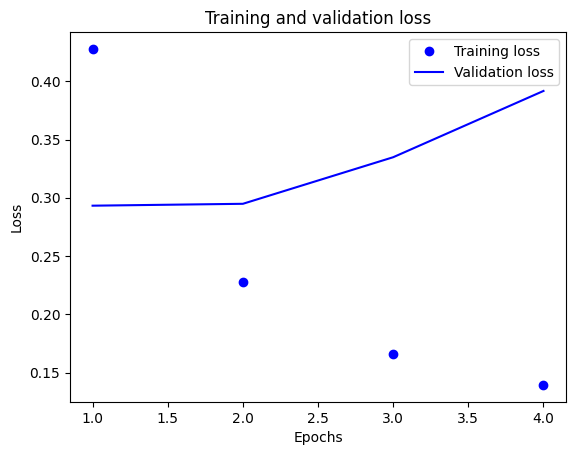

In [54]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

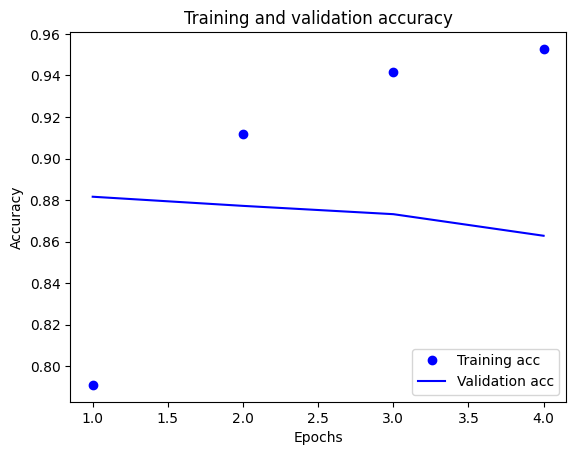

In [55]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Export The Model

In [56]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  attention_model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4997 - loss: 0.5846
{'accuracy': 0.5, 'loss': 0.5836843252182007}


In [57]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


array([[0.73007566],
       [0.50249696],
       [0.5017001 ]], dtype=float32)